Якимова Татьяна ИУ5-65Б

Вариант 22

Датасет содержит информацию о физических характеристиках, здоровье и других параметрах президентов США. В нем есть как числовые (рост, вес, возраст и т. д.), так и категориальные признаки (партия, образование и др.).

Цель: Построить модель для классификации или регрессии. Поскольку в датасете есть столбец "Survived" (выжил ли президент после окончания срока), можно сформулировать задачу бинарной классификации: предсказать, выживет ли президент после окончания срока (1) или нет (0).

Загрузка данных и подготовка к анализу

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

data = pd.read_csv("Historical Presidents Physical Data (More).csv").head(500)

if 'presidency_end_age' in data.columns:
    features = ['height_cm', 'weight_kg', 'body_mass_index', 'presidency_begin_age', 'presidency_end_age', 'political_party', 'birth_year']
else:
    features = ['height_cm', 'weight_kg', 'body_mass_index', 'presidency_begin_age', 'political_party', 'birth_year']

target = 'corrected_iq'

data = data.dropna(subset=[target])


for col in ['height_cm', 'weight_kg', 'body_mass_index', 'presidency_begin_age', 'presidency_end_age', 'birth_year']:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())

data['political_party'] = data['political_party'].fillna('Unknown')

data['weight_to_height_ratio'] = data['weight_kg'] / data['height_cm']
if 'presidency_end_age' in data.columns:
    data['presidency_duration'] = data['presidency_end_age'] - data['presidency_begin_age']

data['height_cm_sq'] = data['height_cm'] ** 2
data['weight_kg_sq'] = data['weight_kg'] ** 2
data['body_mass_index_sq'] = data['body_mass_index'] ** 2

data['birth_year_minus_presidency'] = data['birth_year'] - data['presidency_begin_age']

new_features = features + [
    'weight_to_height_ratio',
    'height_cm_sq',
    'weight_kg_sq',
    'body_mass_index_sq',
    'birth_year_minus_presidency'
]

if 'presidency_end_age' in data.columns:
    new_features.append('presidency_duration')

X = data[new_features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['political_party']
numeric_features = [col for col in new_features if col != 'political_party']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)



corrected_iq            1.000000
body_mass_index        -0.006275
weight_kg              -0.036846
height_cm              -0.077454
presidency_begin_age   -0.204131
Name: corrected_iq, dtype: float64


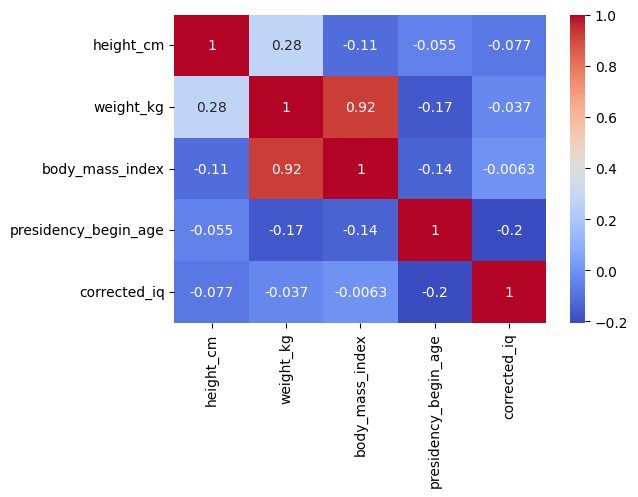

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = data[['height_cm', 'weight_kg', 'body_mass_index', 'presidency_begin_age', 'corrected_iq']].corr()

print(corr['corrected_iq'].sort_values(ascending=False))

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


Построение моделей

1. Метод опорных векторов (SVR)

In [34]:
svr = SVR(kernel='rbf')
svr_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5]
}

svr_grid = GridSearchCV(svr, svr_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
svr_grid.fit(X_train_processed, y_train)

print("Лучшие параметры SVR:", svr_grid.best_params_)

y_pred_svr = svr_grid.predict(X_test_processed)
print("SVR MSE:", mean_squared_error(y_test, y_pred_svr))
print("SVR R²:", r2_score(y_test, y_pred_svr))

Лучшие параметры SVR: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale'}
SVR MSE: 29.752863391841274
SVR R²: -0.058867282398568976


2. Градиентный бустинг (XGBoost)

In [37]:
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train_processed, y_train)

print("Лучшие параметры XGBoost:", xgb_grid.best_params_)

y_pred_xgb = xgb_grid.predict(X_test_processed)
print("XGBoost MSE:", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost R²:", r2_score(y_test, y_pred_xgb))


Лучшие параметры XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.6}
XGBoost MSE: 56.6496652239261
XGBoost R²: -1.0160908976880552


## Оценка качества моделей регрессии
В задаче предсказания corrected_iq (IQ президента) на основе физических и биографических данных были построены две модели:

Метод опорных векторов (SVR)

Градиентный бустинг (XGBoost)

### Для оценки их качества использовались метрики регрессии:

1. Среднеквадратичная ошибка (MSE)

Чем меньше MSE, тем точнее модель.

Штрафует большие ошибки сильнее, чем MAE.

2. Коэффициент детерминации (R²)

R² = 1 → идеальное предсказание.

R² = 0 → модель работает как простое среднее.

R² < 0 → модель хуже, чем предсказание константой.

### Результаты моделей

В ходе работы были обучены две модели для предсказания целевой переменной corrected_iq:

Support Vector Regression (SVR) с ядром RBF

XGBoost Regressor

Значения коэффициента детерминации (R²) для обеих моделей являются отрицательными, что свидетельствует о том, что модели не превосходят простое предсказание среднего значения целевой переменной.

Значение средней квадратичной ошибки (MSE) достаточно высокое, особенно для модели XGBoost, что указывает на низкую точность прогнозов.


## Вывод

Несмотря на проведённую настройку гиперпараметров и предобработку данных, обе модели показывают низкую эффективность на данном наборе признаков и объёме данных.

Модель SVR продемонстрировала относительно лучшие результаты по сравнению с XGBoost, однако качество предсказаний всё равно остаётся неудовлетворительным.

Для улучшения прогноза рекомендуется дополнить набор признаков более информативными переменными, однако какие бы я не добавляла или изменяла признаки, все равно модель плохо обучается.
